In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sznet import build_sz_net
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler, TensorBoard
from sklearn.metrics import  confusion_matrix, classification_report

2023-11-13 21:43:27.810932: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 21:43:28.294496: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 21:43:28.294573: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 21:43:28.296675: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 21:43:28.476977: I tensorflow/core/platform/cpu_feature_g

In [2]:
SUBJECT_DATA_FILE_REGEX = re.compile(r'(\d{1,2}).csv')
METADATA_DIR_PATH = ('./archive')
DATA_DIR_RAW_PATHS = (METADATA_DIR_PATH, './archive2')
STRIPPED_DATA_PATH = ('./stripped')

In [3]:
model = build_sz_net((256, 5, 1))
model.summary()

2023-11-13 21:43:30.509191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 21:43:30.750983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 21:43:30.751439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sznet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 5, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 248, 5, 16)        160       
                                                                 
 batch_normalization (Batch  (None, 248, 5, 16)        64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 248, 5, 16)        0         
                                                                 
 dropout (Dropout)           (None, 248, 5, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 5, 16)        2320      
                                                             

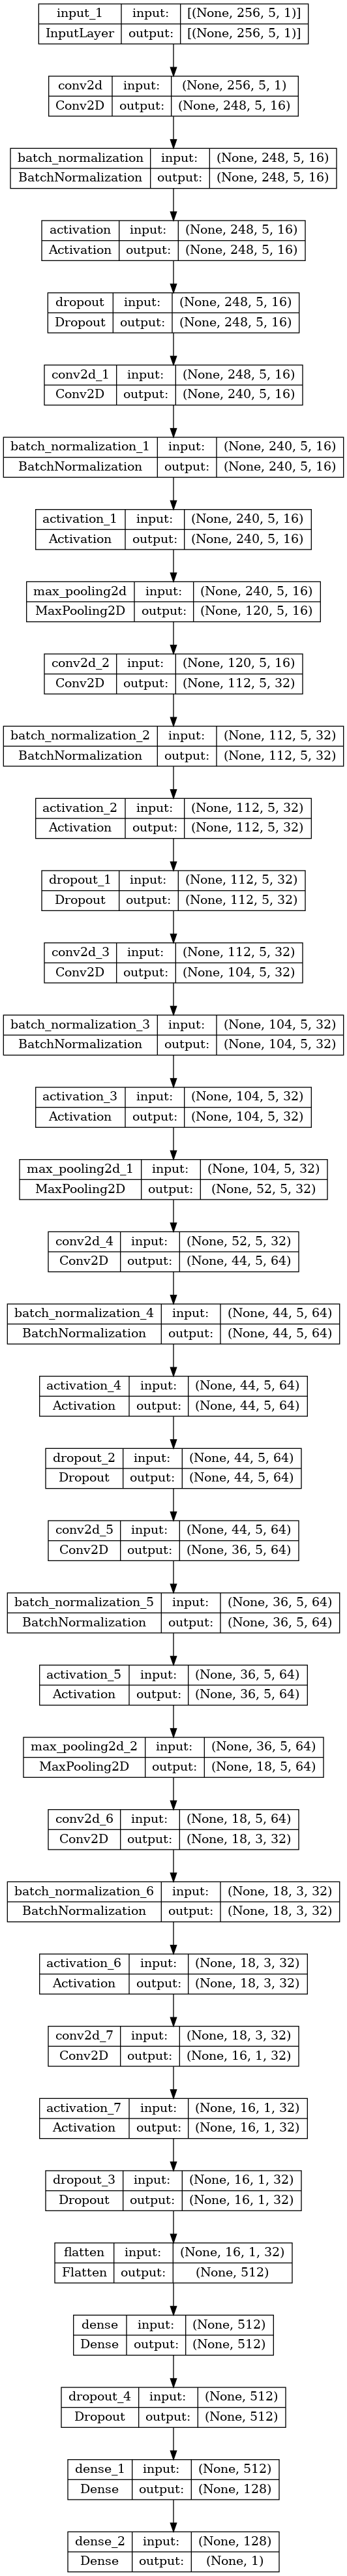

In [4]:
tf.keras.utils.plot_model(model, show_shapes=True)

data format:

```
for each subject (~80):
    for each trial (~100):
        vec = [~3000 x 74 x 3] (time samples x electrodes+stuff x condition)
        only_second_condition = [~3000 x 74] (time samples x electrodes+stuff)
        only_needed = [~3000 x 5] (pick only 5 needed electrodes: Fz, FCz, Cz, CPz, Pz)
        only_needed_in_shortened_time = [512 x 5] (pick time from -100ms to 400ms)
        only_needed_subsampled = [256 x 5] (subsample signal (do this just for completeness sake, try without subsampling too))
        add only_needed_subsampled to the X dataset
        add subject label to Y dataset (0 = healty, 1 = SZ)
```

In [5]:
def build_stripped_dataset(archive_paths=DATA_DIR_RAW_PATHS, target_path=STRIPPED_DATA_PATH, metadata_dir=METADATA_DIR_PATH,
        condition=2, time_min=-100., time_max=400., electrodes=('Fz', 'FCz', 'Cz', 'CPz', 'Pz'),
        subsample=True, time_file_filename='time.csv', column_labels_filename='columnLabels.csv'):
    time_df = pd.read_csv(os.path.join(metadata_dir, time_file_filename))
    column_labels_df = pd.read_csv(os.path.join(metadata_dir, column_labels_filename))
    time_range = time_df[(time_df[' time_ms'] > time_min) & (time_df[' time_ms'] < time_max)]
    min_sample = int(time_range.iloc[0]['sample'])
    max_sample = int(time_range.iloc[-1]['sample'])

    if subsample and (max_sample - min_sample + 1) % 2 == 1:
        max_sample += 1

    try:
        os.mkdir(target_path)
    except FileExistsError:
        pass

    for dir in archive_paths:
        for file_name in tqdm(os.listdir(dir)):
            if SUBJECT_DATA_FILE_REGEX.match(file_name):
                path = os.path.join(dir, file_name, file_name)
                data = pd.read_csv(path)
                data.columns = column_labels_df.columns
                stripped_data = data[(data['condition'] == condition) & (data['sample'] >= min_sample) & (data['sample'] <= max_sample)]
                stripped_data = stripped_data[['trial', 'sample', *electrodes]]
                if subsample:
                    stripped_data_np = stripped_data.to_numpy()
                    subsampled = (stripped_data_np[::2, 1:] + stripped_data_np[1::2, 1:]) / 2
                    subsampled = np.hstack((stripped_data_np[::2, 0].reshape(-1, 1), subsampled))
                    stripped_data = pd.DataFrame(subsampled, columns=stripped_data.columns)
                stripped_data.to_csv(os.path.join(target_path, file_name), index=False)
    
    with open(os.path.join(target_path, 'info.csv'), 'w') as f:
        f.write(f'contidion,time_min,time_max,subsampled\n')
        f.write(f'{condition},{time_min},{time_max},{subsample}\n')

# build_stripped_dataset()

In [6]:
labels = pd.read_csv('./archive/columnLabels.csv')

In [7]:
csv1 = pd.read_csv('./archive2/44.csv/44.csv')

In [8]:
csv1.columns = labels.columns

In [9]:
csv1_prepr = pd.read_csv('./stripped/44.csv')

In [10]:
csv1.describe()

,subject,trial,condition,sample,Fp1,AF7,AF3,F1,F3,F5,...,P10,PO8,PO4,O2,VEOa,VEOb,HEOL,HEOR,Nose,TP10
count,887807.0,887807.000000,887807.00000,887807.000000,887807.000000,887807.000000,887807.000000,887807.000000,887807.000000,887807.000000,...,887807.000000,887807.000000,887807.000000,887807.000000,887807.000000,887807.000000,887807.000000,887807.000000,887807.000000,887807.000000
mean,44.0,49.242259,1.98270,1536.501730,-0.058368,0.023549,0.208894,-0.094736,0.145352,-0.038817,...,0.198712,-0.113832,-0.077242,-0.076054,0.919652,0.263858,-0.549402,0.403265,0.131561,0.263778
std,0.0,28.159891,0.81702,886.809468,8.598968,7.269081,8.717609,9.958434,9.605836,8.966533,...,7.920635,9.356017,10.917907,10.977510,27.933819,21.140853,25.688777,23.737666,15.922234,10.372241
min,44.0,1.000000,1.00000,1.000000,-61.325900,-38.980600,-61.765400,-66.787200,-48.194500,-66.109600,...,-43.217800,-48.237900,-66.046900,-52.314200,-205.132900,-158.637500,-194.041000,-160.937800,-160.739400,-77.765400
25%,44.0,25.000000,1.00000,769.000000,-5.595150,-4.653000,-5.454900,-6.540700,-6.115500,-5.772100,...,-4.706800,-6.225600,-7.153400,-7.295300,-11.794700,-8.070050,-8.379500,-9.921800,-7.278200,-6.224950
50%,44.0,49.000000,2.00000,1537.000000,-0.056800,-0.049400,0.238700,-0.125400,0.135200,-0.041300,...,0.120200,-0.114500,-0.065200,0.005700,0.630500,0.103600,0.273300,0.177400,-0.174400,0.069900
75%,44.0,73.000000,3.00000,2304.500000,5.434600,4.619500,5.887300,6.228800,6.371700,5.628900,...,5.044200,5.985800,7.041600,7.146200,12.182100,8.226000,8.777300,10.221950,6.891300,6.578100
max,44.0,99.000000,3.00000,3072.000000,49.153300,39.376400,46.914600,57.099000,50.761600,47.742500,...,42.893100,65.850900,63.326500,54.629200,334.048600,201.942100,165.401800,353.697400,155.707400,87.058000


<Axes: xlabel='sample', ylabel='Cz'>

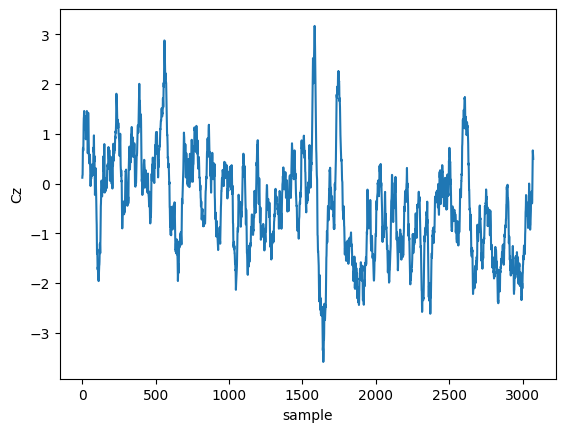

In [11]:
sns.lineplot(csv1[(csv1['condition'] == 2)][['sample', 'Cz']].groupby(['sample']).mean(), x='sample', y='Cz')

In [12]:
csv1_prepr.describe()

,trial,sample,Fz,FCz,Cz,CPz,Pz
count,24576.000000,24576.000000,24576.000000,24576.000000,24576.000000,24576.000000,24576.000000
mean,49.697917,1690.500000,-0.239756,-0.348574,-0.606235,-0.528728,-0.501137
std,28.016979,147.803548,8.743111,9.509758,9.939041,9.903317,9.711517
min,1.000000,1435.500000,-39.784550,-45.813850,-45.442250,-44.803800,-44.969900
25%,25.750000,1563.000000,-5.948550,-6.574825,-6.977462,-6.920900,-7.007187
50%,49.500000,1690.500000,-0.211975,-0.288175,-0.379725,-0.374650,-0.371225
75%,73.250000,1818.000000,5.518375,5.856025,5.845838,5.877625,5.913300
max,98.000000,1945.500000,33.199500,35.333450,40.110450,40.239100,33.260600


<Axes: xlabel='sample', ylabel='Cz'>

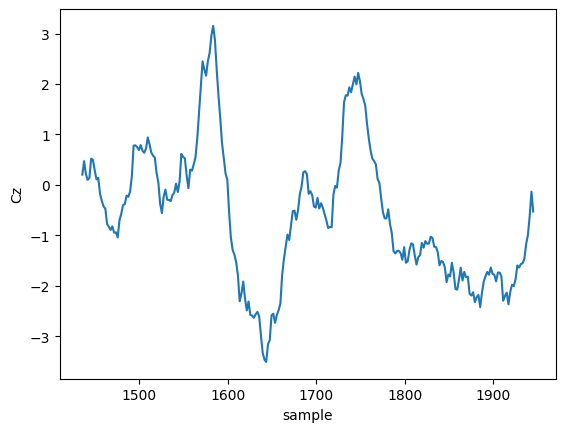

In [13]:
sns.lineplot(csv1_prepr[['sample', 'Cz']].groupby(['sample']).mean(), x='sample', y='Cz')

In [14]:
demographic = pd.read_csv(os.path.join(METADATA_DIR_PATH, 'demographic.csv')).set_index('subject')
demographic.loc[44][' group']

1

In [15]:
def load_data(metadata_dir=METADATA_DIR_PATH, data_dir=STRIPPED_DATA_PATH) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    demographic = pd.read_csv(os.path.join(metadata_dir, 'demographic.csv')).set_index('subject')
    X, Y, idxs = [], [], []

    filenames = []
    for file_name in os.listdir(data_dir):
        if match := SUBJECT_DATA_FILE_REGEX.match(file_name):
            subject_id = int(match.group(1))
            filenames.append((file_name, subject_id))

    np.random.shuffle(filenames)

    for file_name, subject_id in filenames:
        # 0 -> healthy, 1 -> SZ
        health_class = demographic.loc[subject_id][' group']

        data = pd.read_csv(os.path.join(data_dir, file_name))
        trials = data['trial'].unique()

        for trial in trials:
            trial_data = data[data['trial'] == trial]
            X.append(trial_data.drop(['trial', 'sample'], axis=1).to_numpy())
        
        Y.extend([health_class] * len(trials))
        idxs.extend([subject_id] * len(trials))

    return np.stack(X, axis=0), np.stack(Y, axis=0), np.stack(idxs, axis=0)

In [16]:
x, y, idxs = load_data()

In [17]:
def preprocess(X: np.ndarray, idxs: np.ndarray, standardize=False) -> np.ndarray:
    min_x = np.min(X, axis=1).reshape((X.shape[0], 1, -1))
    max_x = np.max(X, axis=1).reshape((X.shape[0], 1, -1))
    scaled = (X - min_x) / (max_x - min_x)
    standardized = scaled

    if standardize:
        # per subject standarization
        # for idx in np.unique(idxs):
        #     subject_data = standardized[np.where(idxs == idx)]
        #     standardized[np.where(idxs == idx)] = (subject_data - np.mean(subject_data, axis=0)) / np.std(subject_data, axis=0)
        standardized = (standardized - np.mean(standardized, axis=1)[:,np.newaxis,:]) / np.std(standardized, axis=1)[:,np.newaxis,:]

    return standardized

In [18]:
x, y, idxs = load_data()

In [19]:
x = preprocess(x, idxs, standardize=True)

In [23]:
def build_tfds(x: np.ndarray, y: np.ndarray, batch_size: int):
    tfds = tf.data.Dataset.from_tensor_slices((x, y))
    tfds = tfds.shuffle(x.shape[0])
    tfds = tfds.batch(batch_size)
    tfds = tfds.prefetch(tf.data.experimental.AUTOTUNE)
    return tfds

In [27]:
# def load_and_preprocess(test_size=0.1, val_size=0.15):
#     x, y, idxs = load_data()
#     x = preprocess(x)
#     train_idxs, test_idxs = train_test_split(np.unique(idxs), test_size=test_size)
#     train_idxs, val_idxs = train_test_split(train_idxs, test_size=val_size)
#     train_idxs0 = train_idxs
#     train_idxs = np.isin(idxs, train_idxs)
#     test_idxs = np.isin(idxs, test_idxs)
#     val_idxs = np.isin(idxs, val_idxs)
#     train_x, val_x, test_x = x[train_idxs], x[val_idxs], x[test_idxs]
#     train_y, val_y, test_y = y[train_idxs], y[val_idxs], y[test_idxs]
#     return x, y, idxs, train_idxs0, train_idxs, (train_x, train_y), (val_x, val_y), (test_x, test_y)

def load_and_preprocess(test_size=0.1, val_size=0.15, standardize=False):
    x, y, idxs = load_data()
    x = preprocess(x, idxs, standardize=standardize)
    train_idxs, test_idxs = train_test_split(np.unique(idxs), test_size=test_size)
    if val_size is not None:
        train_idxs, val_idxs = train_test_split(train_idxs, test_size=val_size)
    train_idxs0 = train_idxs
    train_idxs = np.isin(idxs, train_idxs)
    test_idxs = np.isin(idxs, test_idxs)
    if val_size is not None:
        val_idxs = np.isin(idxs, val_idxs)
        val_x = x[val_idxs]
        val_y = y[val_idxs]
    else:
        val_x, val_y = None, None
    train_x, test_x = x[train_idxs], x[test_idxs]
    train_y, test_y = y[train_idxs], y[test_idxs]
    return x, y, idxs, train_idxs0, train_idxs, (train_x, train_y), (val_x, val_y), (test_x, test_y)

def load_and_preprocess_same_proportion_of_sz_hc(test_size=0.1, val_size=0.15, standardize=False):
    x, y, idxs = load_data()
    x = preprocess(x, idxs, standardize=standardize)

    all_idxs = np.unique(idxs)
    healthy_idxs = []
    sz_idxs = []
    for idx in all_idxs:
        if y[np.where(idxs == idx)][0] == 0:
            healthy_idxs.append(idx)
        else:
            sz_idxs.append(idx)

    sz_fraq = len(sz_idxs) / len(all_idxs)
    h_fraq = 1 - sz_fraq

    train_idxs_hc, test_idxs_hc = train_test_split(healthy_idxs, test_size=test_size * h_fraq)
    train_idxs_hc, val_idxs_hc = train_test_split(train_idxs_hc, test_size=val_size * h_fraq)

    train_idxs_sz, test_idxs_sz = train_test_split(sz_idxs, test_size=test_size * sz_fraq)
    train_idxs_sz, val_idxs_sz = train_test_split(train_idxs_sz, test_size=val_size * sz_fraq)

    train_idxs = [*train_idxs_hc, *train_idxs_sz]
    test_idxs = [*test_idxs_hc, *test_idxs_sz]
    val_idxs = [*val_idxs_hc, *val_idxs_sz]

    train_idxs0 = train_idxs
    train_idxs = np.isin(idxs, train_idxs)
    test_idxs = np.isin(idxs, test_idxs)
    if val_size is not None:
        val_idxs = np.isin(idxs, val_idxs)
        val_x = x[val_idxs]
        val_y = y[val_idxs]
    else:
        val_x, val_y = None, None
    train_x, test_x = x[train_idxs], x[test_idxs]
    train_y, test_y = y[train_idxs], y[test_idxs]
    return x, y, idxs, train_idxs0, train_idxs, (train_x, train_y), (val_x, val_y), (test_x, test_y)

In [28]:
def train_sznet(train: tuple[np.ndarray, np.ndarray], val: tuple[np.ndarray, np.ndarray],
                batch_size=4, epochs=300, learning_rate=1e-4, model_path="model_v1.h5", initial_model=None):
    train_x = train[0]
    if initial_model is None:
        model = build_sz_net((train_x.shape[1], train_x.shape[2], 1), dropout=0.25, dense_dropout=0.5, l2_regularization_coef=1e-4)
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=Adam(learning_rate), metrics=['accuracy'])
    else:
        model = initial_model
    callbacks = [
        # ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=False, start_from_epoch=60),
        CSVLogger(f'{model_path}.log.csv'),
        TensorBoard(
            f'{model_path}.log.tfboard',
            update_freq='epoch'
        )
    ]
    train_tfds = build_tfds(*train, batch_size)
    vald_tfds = build_tfds(*val, batch_size)

    return model.fit(train_tfds, validation_data=vald_tfds, epochs=epochs, callbacks=callbacks)

In [29]:
xx, yy, idxs, tidx0, tidx1, train, val, test = load_and_preprocess_same_proportion_of_sz_hc(test_size=0.1, val_size=0.1, standardize=True)

In [30]:
res = train_sznet(train, val, learning_rate=8e-5, batch_size=8)

Epoch 1/300


2023-11-13 21:45:12.445282: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insznet/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-13 21:45:13.875131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-13 21:45:16.008645: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff7d00ad660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-13 21:45:16.008693: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-11-13 21:45:16.013545: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-13 21:45:16.076486: I ./tensorflow/compiler/jit/device_compiler.h:186] Compile

835/835 [==============================] - 17s 13ms/step - loss: 0.7849 - accuracy: 0.5787 - val_loss: 0.7745 - val_accuracy: 0.5979
Epoch 2/300
835/835 [==============================] - 11s 14ms/step - loss: 0.7644 - accuracy: 0.6039 - val_loss: 0.7803 - val_accuracy: 0.5938
Epoch 3/300
835/835 [==============================] - 8s 10ms/step - loss: 0.7577 - accuracy: 0.6123 - val_loss: 0.7811 - val_accuracy: 0.5979
Epoch 4/300
835/835 [==============================] - 8s 10ms/step - loss: 0.7551 - accuracy: 0.6130 - val_loss: 0.7795 - val_accuracy: 0.5979
Epoch 5/300
835/835 [==============================] - 10s 11ms/step - loss: 0.7514 - accuracy: 0.6129 - val_loss: 0.7783 - val_accuracy: 0.5958
Epoch 6/300
835/835 [==============================] - 7s 8ms/step - loss: 0.7454 - accuracy: 0.6166 - val_loss: 0.7768 - val_accuracy: 0.5917
Epoch 7/300
835/835 [==============================] - 9s 10ms/step - loss: 0.7485 - accuracy: 0.6148 - val_loss: 0.7733 - val_accuracy: 0.5979
Ep

KeyboardInterrupt: 

In [ ]:
preds = res.model.predict(test[0])

16/16 [==============================] - 0s 10ms/step


In [ ]:
ppreds = (preds > 0.5).astype(np.uint8)

In [ ]:
np.sum(ppreds.squeeze() == test[1]) / test[1].shape[0]

0.5717255717255717

In [ ]:
display(confusion_matrix(test[1], ppreds))
print(classification_report(test[1], ppreds))

array([[ 65, 131],
       [ 75, 210]])

              precision    recall  f1-score   support

           0       0.46      0.33      0.39       196
           1       0.62      0.74      0.67       285

    accuracy                           0.57       481
   macro avg       0.54      0.53      0.53       481
weighted avg       0.55      0.57      0.56       481



In [ ]:
preds = res.model.predict(val[0])

 1/15 [=>............................] - ETA: 0s

15/15 [==============================] - 0s 12ms/step


In [ ]:
ppreds = (preds > 0.5).astype(np.uint8)

In [ ]:
np.sum(ppreds.squeeze() == val[1]) / val[1].shape[0]

0.5429184549356223